## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the first 2). You might need to invoke the cell below here to see the graph.

In [16]:
%load_ext autoreload
%autoreload 2

Peaks: ['3.0e+10', '1.4e+09', '1.1e+09', '1.2e+09']
Time 0.014761904761904763
Speed of Sound 346.45
Distance 1.2785654761904761


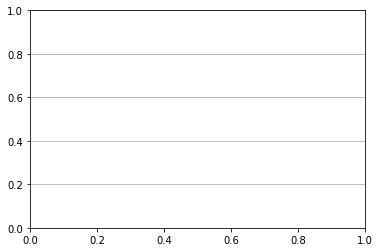

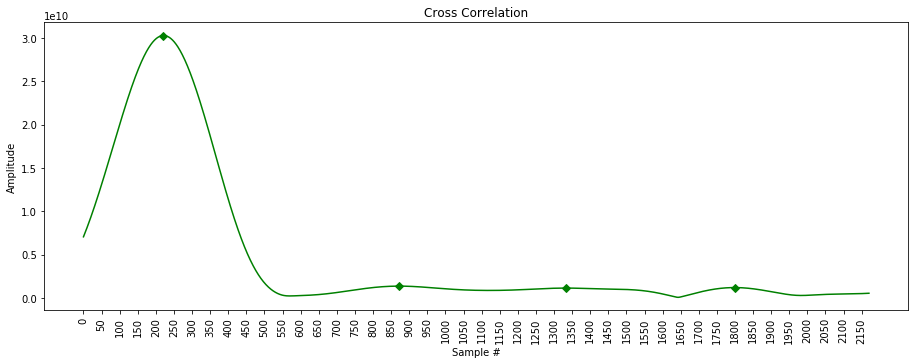

------
Peaks: ['3.0e+10', '1.3e+09', '1.3e+09', '9.8e+08', '4.3e+08']
Time 0.014875283446712018
Speed of Sound 346.45
Distance 1.2883854875283445


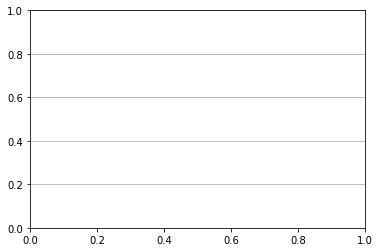

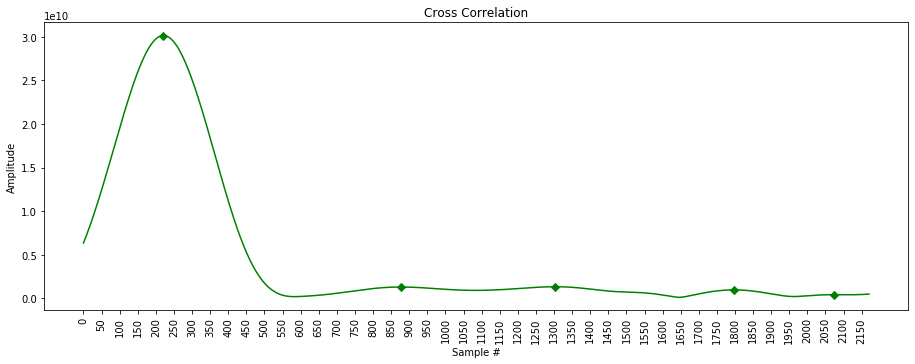

------
Peaks: ['3.0e+10', '1.4e+09', '8.3e+08', '8.1e+08', '9.6e+08', '5.0e+08']
Time 0.014761904761904763
Speed of Sound 346.45
Distance 1.2785654761904761


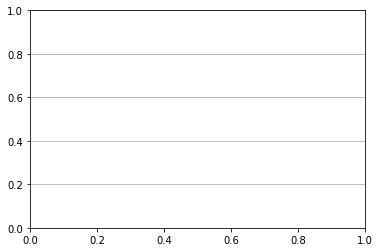

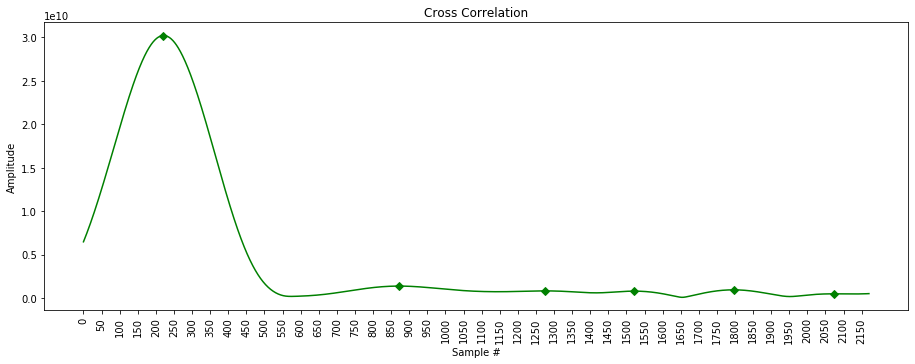

------
Peaks: ['3.0e+10', '1.4e+09', '1.2e+09', '8.4e+08', '4.8e+08']
Time 0.014807256235827664
Speed of Sound 346.45
Distance 1.2824934807256236


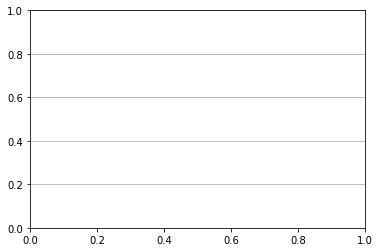

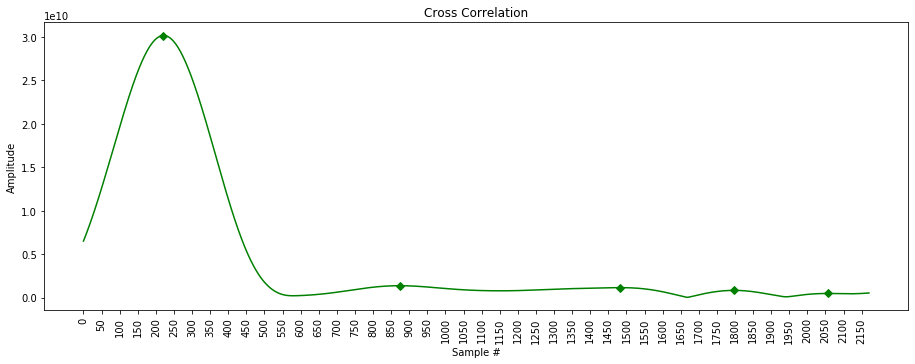

------
Peaks: ['3.0e+10', '1.2e+09', '1.0e+09', '1.1e+09', '9.3e+08']
Time 0.014875283446712018
Speed of Sound 346.45
Distance 1.2883854875283445


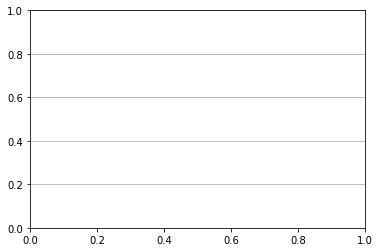

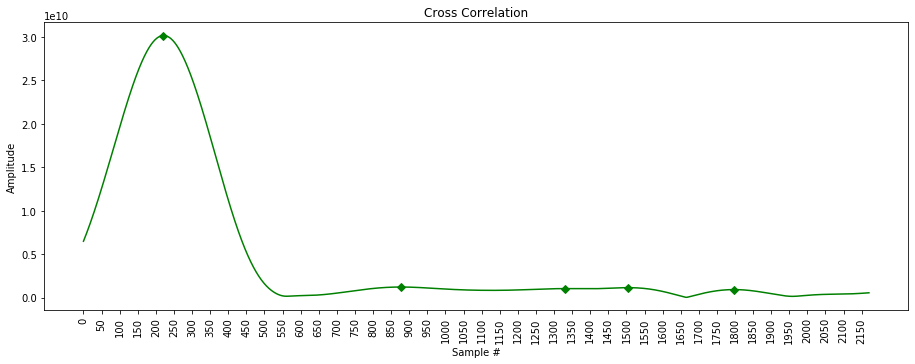

------
Peaks: ['3.0e+10', '1.4e+09', '1.1e+09', '9.3e+08', '7.9e+08']
Time 0.014852607709750568
Speed of Sound 346.45
Distance 1.286421485260771


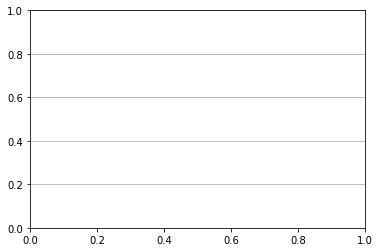

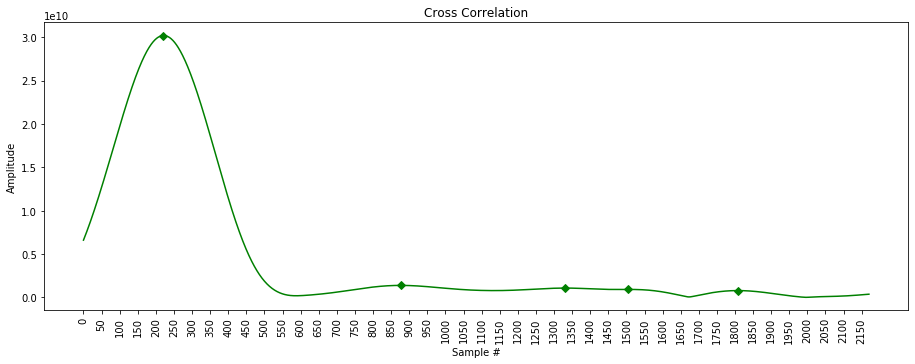

------
Peaks: ['3.0e+10', '1.4e+09', '9.3e+08', '1.2e+09', '8.2e+08', '4.5e+08']
Time 0.01473922902494331
Speed of Sound 346.45
Distance 1.2766014739229026


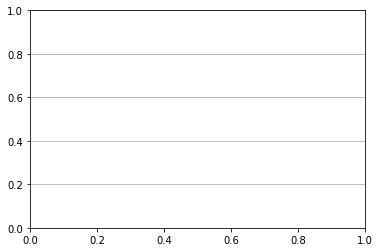

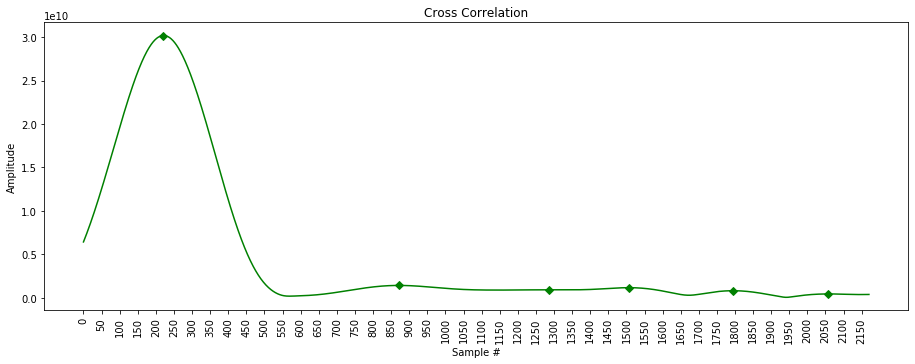

------
Peaks: ['3.0e+10', '1.3e+09', '1.4e+09', '7.4e+08', '4.6e+08']
Time 0.014693877551020407
Speed of Sound 346.45
Distance 1.272673469387755


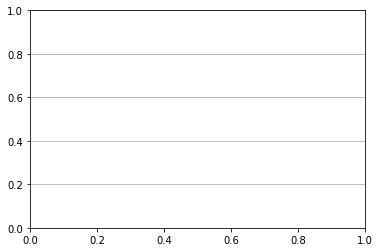

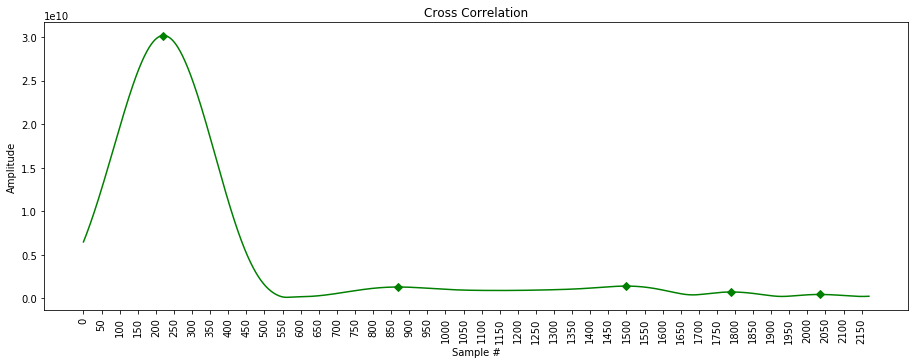

------
Peaks: ['3.0e+10', '1.4e+09', '1.2e+09', '1.2e+09', '8.6e+08', '3.4e+08']
Time 0.014761904761904763
Speed of Sound 346.45
Distance 1.2785654761904761


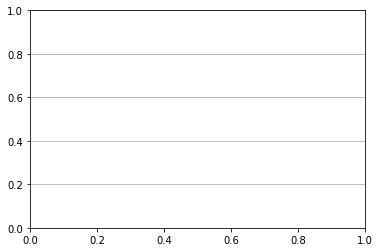

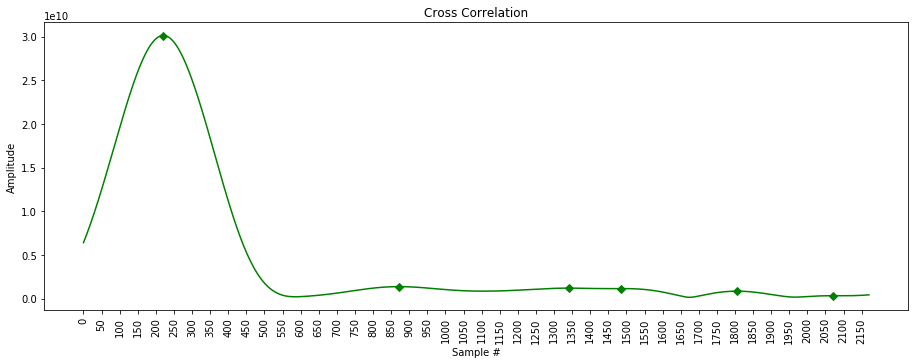

------
Peaks: ['3.0e+10', '1.3e+09', '1.1e+09', '1.1e+09', '6.1e+08']
Time 0.014671201814058957
Speed of Sound 346.45
Distance 1.2707094671201815


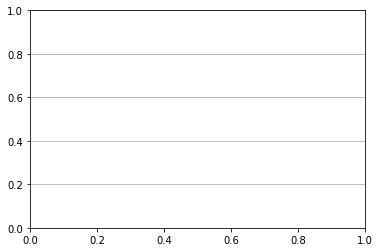

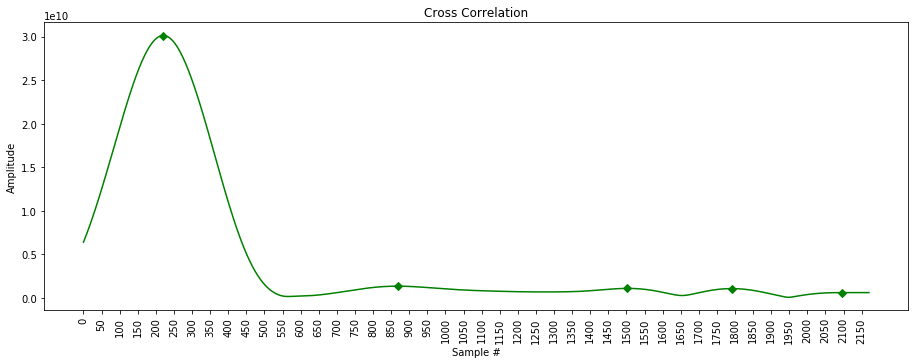

------
Avg distance: 1.280136678004535


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import analysis
import cross_correlation_analyzer as cca
import numpy as np
from scipy import signal

threshold = 2e7

distances = []
print_format = "Time {0}\nSpeed of Sound {1}\nDistance {2}"
for sample_number in range(1, 11):
    cc = cca.get_cc(sample_number)
    time_delta, speed_of_sound, half_distance, peaks = \
        cca.get_distances(cc, threshold)
    distances.append(half_distance)
    print("Peaks: {}".format(["{0:.1e}".format(cc[p]) for p in peaks]))
    print(print_format.format(time_delta, speed_of_sound, half_distance))
    analysis.get_graph_figure(cc, 'Cross Correlation', markers=peaks)
    print("------")

print("Avg distance: {}".format(np.mean(distances)))